In [19]:
%reset -f
%clear

In [20]:
import torch
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from utils.model_util import LeNet5, CNN
from utils.data_util import *
from utils.lib_util import *
from utils.train_util import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
torch.set_printoptions(precision=2,
                       threshold=1000,
                       edgeitems=5,
                       linewidth=1000,
                       sci_mode=False)
# 是否使用显卡加速
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [21]:
# %% 参数定义
alpha = 0.5
num_server_commu = 5
num_client_commu = 5
num_client_train = 5
num_public_train = 2

num_all_client = 6
num_all_server = 2
num_client_data = 1000
all_client = number_list(num_all_client)
all_server = number_list(num_all_server)
server_client_1 = [0, 1, 2]
server_client_2 = [3, 4, 5]
server_client = [server_client_1, server_client_2]
neighbor_server = [[1], [0]]

In [22]:
# %% 原始数据处理
save_path = './data/dealed-data/'
dataset = 'mnist'
train_dataset_o, test_dataset_o, c, h, w = get_dataset(dataset)
TrainDatasetSplited = SplitData(train_dataset_o)
all_target = TrainDatasetSplited.targets
num_target = TrainDatasetSplited.num_target
train_dataset_client = TrainDatasetSplited.all_iid(
    num_all_client, num_client_data)

public_idx, test_idx = split_idx_proportion(
    number_list(len(test_dataset_o)), [0.2, 0.8])
public_dataset = DealDataset(test_dataset_o, public_idx)
test_dataset = DealDataset(test_dataset_o, test_idx)

In [23]:
print(c, h, w)
print(len(train_dataset_client), len(train_dataset_client[0]))

1 28 28
6 1000


In [24]:
# %% 模型初始化
initial_model = LeNet5(h, w, c, num_target)

client_model = list_same_term(num_all_client, initial_model)
server_model = list_same_term(num_all_server)
server_accuracy = list_same_term(num_all_server)
client_accuracy = list_same_term(num_all_client)
server_client_model = list_same_term(num_all_server)
server_model_distillation_accuracy = list_same_term(num_all_server)

In [25]:
# %% 模型训练
# 对每个服务器通讯幕进行循环
for epoch_server_commu in range(num_server_commu):
# for epoch_server_commu in tqdm(range(num_server_commu), desc='epoch_server_commu', position=0, leave=False):
    # 所有边缘服务器分别协调其客户端进行多轮联邦学习
    for epoch_client_commu in range(num_client_commu):
    # for epoch_client_commu in tqdm(range(num_client_commu), desc='epoch_client_commu', position=1, leave=False):
        # 所有边缘服务器分别协调其客户端进行联邦学习
        for server in all_server:
        # for server in tqdm(all_server, desc='server', position=2, leave=False):
            # 每个服务器下单客户端分别训练
            for client in server_client[server]:
            # for client in tqdm(server_client[server], desc='client', position=3, leave=False):
                # 单个服务器下的客户端在私有数据集上进行num_client_train轮训练
                client_model[client], loss_sum = train_model(
                    model=client_model[client],
                    dataset=train_dataset_client[client],
                    device=device,
                    epochs=num_client_train)
                # 单个服务器下的客户端在公开数据集上进行num_public_train轮训练
                if epoch_server_commu != 0:
                    neighbor_server_model = [
                        server_model_distillation[server] for server in neighbor_server[server]]
                    weight = torch.tensor(
                        [1/len(neighbor_server_model) for _ in neighbor_server_model])
                    client_model[client], loss_sum = train_model_disti(
                        model=client_model[client],
                        neighbor_server_model=neighbor_server_model,
                        weight=weight,
                        dataset=public_dataset,
                        device=device,
                        epochs=num_public_train,
                        num_target=len(all_target),
                        alpha=alpha)
                # 在训练后评估该服务器下的客户端
                client_accuracy[client].append(eval_model(
                    client_model[client], test_dataset, device))
            # 在单个服务器下客户端训练完成后更新该服务器下客户端的模型
            server_client_model[server] = [client_model[client]
                                           for client in server_client[server]]
            # 聚合获得单个服务器模型
            server_model[server] = EdgeServer(
                server_client_model[server]).average()
            # 评估单个服务器模型
            server_accuracy[server].append(eval_model(server_model[server], test_dataset, device).cpu())
    # 服务器在多轮更新联邦学习后固定用于蒸馏的模型
    server_model_distillation = deepcopy(server_model)
    # 评估该蒸馏模型
    for server in all_server:
        server_model_distillation_accuracy[server].append(eval_model(
            server_model_distillation[server], test_dataset, device).cpu())

epoch_server_commu:   0%|          | 0/5 [00:00<?, ?it/s]























































































































epoch_server_commu:  20%|██        | 1/5 [00:29<01:59, 29.87s/it]























































































































epoch_server_commu:  40%|████      | 2/5 [01:09<01:45, 35.32s/it]























































































































epoch_server_commu:  60%|██████    | 3/5 [01:47<01:13, 36.81s/it]























































































































epoch_server_commu:  80%|████████  | 4/5 [02:26<00:37, 37.55s/it]

























































































































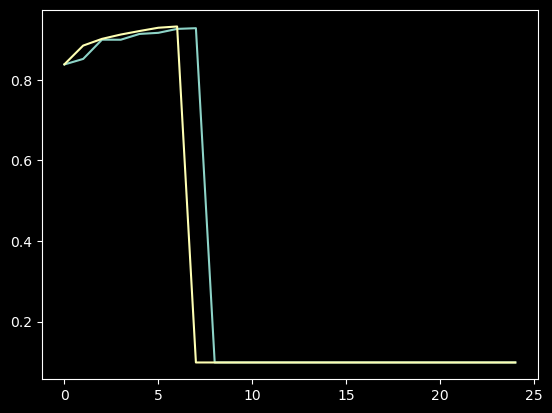

In [26]:
# %% 作图
x = [i for i in range(num_server_commu * num_client_commu)]
line_list = []
for server in all_server:
    line_list.append(plt.plot(x, server_accuracy[server]))

plt.show()